<a href="https://colab.research.google.com/github/SalhaAlzahrani/DiagnosticMLP/blob/main/Summary_DiagnosticMLP_Baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟨 Summary of model architectures: DiagnosticMLP vs. Modern MLP models


In [ ]:
!pip install nest_asyncio
!pip install -U -q tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 3.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
import math
import nest_asyncio
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Mounted at /content/drive




---

## 🟡 plot_training_curves

In [ ]:
def plot_training_curves(history, title):
    loss = np.array(history.history['loss'])
    val_loss = np.array(history.history['val_loss'])
    epochs = range(len(history.history['loss']))
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    plt.style.use('_mpl-gallery') #ggplot #bmh
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 2.5))
    fig.patch.set_facecolor('xkcd:white')

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.', )
    ax1.plot(epochs, val_loss, label='val_loss', marker='.', )
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+title, fontsize=10)
    ax1.set_xlabel('Epochs', fontsize=10)
    ax1.legend(fontsize=10)

    # Plot accuracy
    ax2.set_ylim(ymin=0, ymax=1.1)
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+title, fontsize=10)
    ax2.set_xlabel('Epochs', fontsize=10)
    ax2.legend(fontsize=10)

## 🟡 Hyperparameters


In [ ]:
path = '/content/drive/MyDrive/_MyResearch_/CT_Datasets/Computed Tomography (CT) of the Abdomen/'

image_size = 64 # We'll resize input images to this size.
input_shape = (64, 64, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 100
dropout_rate = 0.2
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


## 🟡 Dataset


In [ ]:
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(image_size, image_size),
    color_mode='rgb',
    seed=128,
    validation_split=0.1,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(image_size, image_size),
    color_mode='rgb',
    seed=128,
    validation_split=0.1,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 1428 files belonging to 9 classes.
Using 1286 files for training.
Found 1428 files belonging to 9 classes.
Using 142 files for validation.


In [ ]:
class_names = train_ds.class_names
print(class_names)
##################
num_classes = len(class_names)
##################
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(num_classes): classes.append(i)
class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

['abdominal_aorta_dilatation', 'aneurysmal_dilatation_of_aorta', 'aortic_aneurysm', 'cancer', 'formation_of_adrenal_gland', 'kidney_development', 'liver_formation', 'urolithiasis', 'vertebral_compression_fracture']


{0: 1.1581508515815084,
 1: 1.017094017094017,
 2: 0.9558232931726908,
 3: 0.9500998003992016,
 4: 1.0507726269315674,
 5: 1.0042194092827004,
 6: 0.9855072463768116,
 7: 0.8766114180478821,
 8: 1.0507726269315674}

In [ ]:
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

## 🟡 Classification model
We implement a method that builds a classifier given the processing blocks.

In [ ]:
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)

## 🟡 Experiment
We implement a utility function to compile, train, and evaluate a given model.

In [ ]:
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
            keras.metrics.MeanSquaredError(name='Brier score'),
            keras.metrics.F1Score(name='F1 score'),
            keras.metrics.Recall(name='Recall'),
            keras.metrics.Precision(name='Precision'),
            keras.metrics.AUC(name='AUC'),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        train_ds,
        validation_data = val_ds,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
    )
    # Return history to plot learning curves.
    return history

## 🟡 Augmentation


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip('horizontal_and_vertical'),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
        layers.RandomContrast(factor=0.2),
        layers.RandomCrop(height=image_size, width=image_size),
        layers.RandomBrightness(factor=0.2),
    ],
    name="data_augmentation",
)

## 🟡 Patch extraction


In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches

# ⚛ MLP-Mixer model
The MLP-Mixer is an architecture based exclusively on multi-layer perceptrons (MLPs), that contains two types of MLP layers:

One applied independently to image patches, which mixes the per-location features.
The other applied across patches (along channels), which mixes spatial information.
This is similar to a depthwise separable convolution based model such as the Xception model, but with two chained dense transforms, no max pooling, and layer normalization instead of batch normalization.



In [ ]:
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

In [ ]:
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
mlpmixer_classifier = build_classifier(mlpmixer_blocks)

In [ ]:
mlpmixer_classifier.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 data_augmentation (Sequent  (None, 64, 64, 3)         7         
 ial)                                                            
                                                                 
 patches (Patches)           (None, 64, 192)           0         
                                                                 
 dense_16 (Dense)            (None, 64, 256)           49408     
                                                                 
 sequential_8 (Sequential)   (None, 64, 256)           167680    
                                                                 
 global_average_pooling1d (  (None, 256)               0         
 GlobalAveragePooling1D)                                     

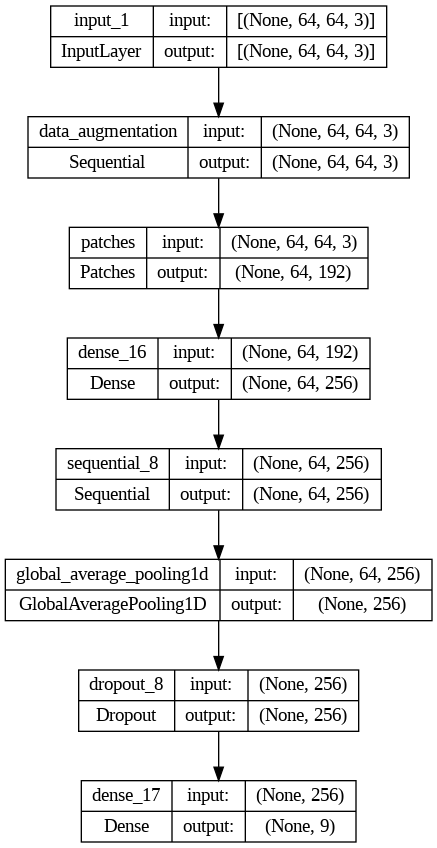

In [ ]:
dot_img_file = '/tmp/model_1.png'
keras.utils.plot_model(mlpmixer_classifier, to_file=dot_img_file, show_shapes=True)


# ⚛ FNet model
The FNet uses a similar block to the Transformer block. However, FNet replaces the self-attention layer in the Transformer block with a parameter-free 2D Fourier transformation layer:

- One 1D Fourier Transform is applied along the patches.
- One 1D Fourier Transform is applied along the channels.

In [ ]:
class FNetLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.ffn = keras.Sequential(
            [
                layers.Dense(units=embedding_dim),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
                layers.Dense(units=embedding_dim),
            ]
        )
        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )
        # Add skip connection.
        x = x + inputs
        # Apply layer normalization.
        x = self.normalize1(x)
        # Apply Feedfowrad network.
        x_ffn = self.ffn(x)
        # Add skip connection.
        x = x + x_ffn
        # Apply layer normalization.
        return self.normalize2(x)

In [ ]:
fnet_blocks = keras.Sequential(
    [FNetLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
fnet_classifier = build_classifier(fnet_blocks, positional_encoding=True)

In [ ]:
fnet_classifier.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 data_augmentation (Sequent  (None, 64, 64, 3)         7         
 ial)                                                            
                                                                 
 patches_1 (Patches)         (None, 64, 192)           0         
                                                                 
 dense_26 (Dense)            (None, 64, 256)           49408     
                                                                 
 tf.__operators__.add (TFOp  (None, 64, 256)           0         
 Lambda)                                                         
                                                                 
 sequential_13 (Sequential)  (None, 64, 256)           5304

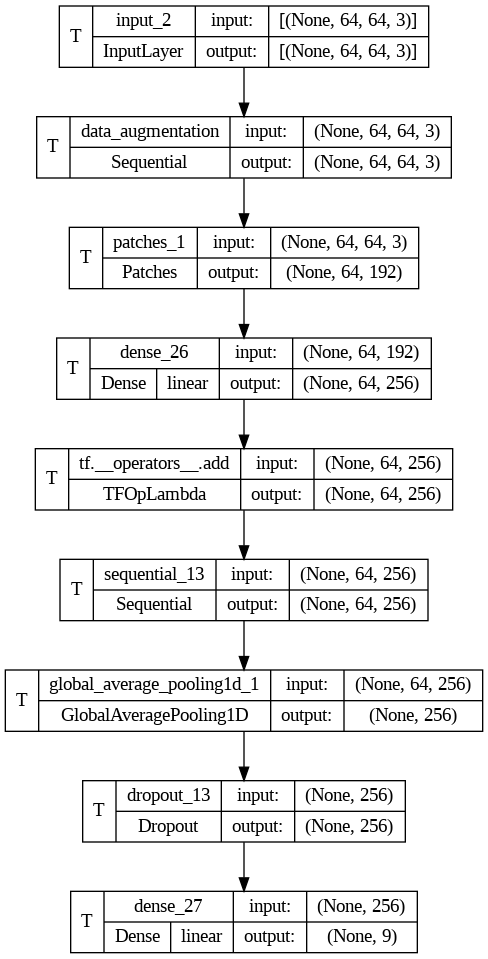

In [ ]:
keras.utils.plot_model(fnet_classifier, show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       expand_nested=False,
                       show_layer_activations=True,
                       show_trainable=True,)

As shown in the FNet paper, better results can be achieved by increasing the embedding dimensions, increasing the number of FNet blocks, and training the model for longer. You may also try to increase the size of the input images and use different patch sizes. The FNet scales very efficiently to long inputs, runs much faster than attention-based Transformer models, and produces competitive accuracy results.



---



# ⚛ gMLP model
The gMLP is a MLP architecture that features a Spatial Gating Unit (SGU). The SGU enables cross-patch interactions across the spatial (channel) dimension, by:

- Transforming the input spatially by applying linear projection across patches (along channels).
- Applying element-wise multiplication of the input and its spatial transformation.


In [ ]:
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.channel_projection2 = layers.Dense(units=embedding_dim)
        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )
        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected

In [ ]:
gmlp_blocks = keras.Sequential(
    [gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
gmlp_classifier = build_classifier(gmlp_blocks)

In [ ]:
gmlp_classifier.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 data_augmentation (Sequent  (None, 64, 64, 3)         7         
 ial)                                                            
                                                                 
 patches_2 (Patches)         (None, 64, 192)           0         
                                                                 
 dense_40 (Dense)            (None, 64, 256)           49408     
                                                                 
 sequential_18 (Sequential)  (None, 64, 256)           810240    
                                                                 
 global_average_pooling1d_2  (None, 256)               0         
  (GlobalAveragePooling1D)                                 

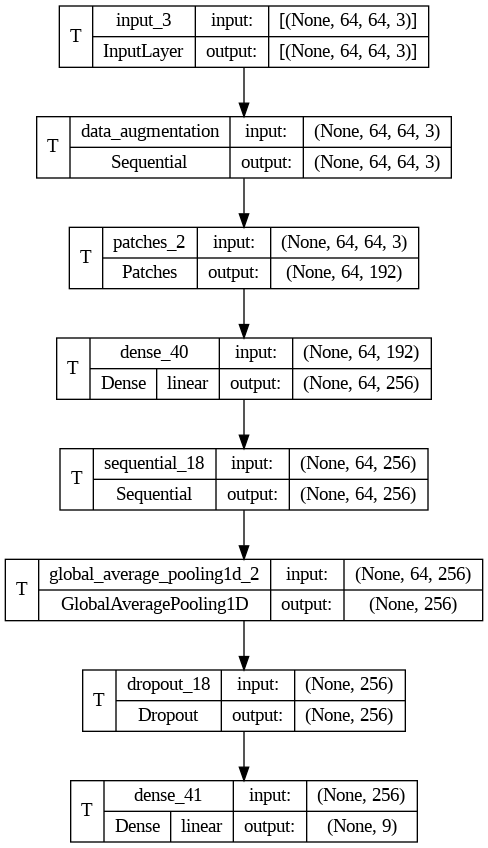

In [ ]:
keras.utils.plot_model(gmlp_classifier, show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       expand_nested=False,
                       show_layer_activations=True,
                       show_trainable=True,)

As shown in the gMLP paper, better results can be achieved by increasing the embedding dimensions, increasing the number of gMLP blocks, and training the model for longer. You may also try to increase the size of the input images and use different patch sizes. Note that, the paper used advanced regularization strategies, such as MixUp and CutMix, as well as AutoAugment.



---



# ⚛ ResMLP

In [ ]:
class Affine(tf.keras.layers.Layer):
    def __init__(self, n_channels:int, biased:bool):
        super(Affine, self).__init__()
        self.n_channels = n_channels
        self.biased = biased
        self.a = tf.Variable(tf.ones([1,1,self.n_channels]), dtype = 'float32') if self.biased else tf.Variable(tf.random.normal([1,1,self.n_channels], 0, 0.001), dtype = 'float32')
        self.b = tf.Variable(tf.zeros([1,1,self.n_channels]), dtype = 'float32') if self.biased else None

    def call(self, X):
        X = X * self.a
        if self.biased:
            X = X + self.b
        return X

class ResLayer(tf.keras.layers.Layer):
    def __init__(self, n_dims:int, n_patches:int):
        super(ResLayer, self).__init__()
        self.n_dims = n_dims
        self.n_patches = n_patches
        self.affine_pre1 = Affine(self.n_dims, True)
        self.affine_pre2 = Affine(self.n_dims, True)
        self.affine_pos1 = Affine(self.n_dims, False)
        self.affine_pos2 = Affine(self.n_dims, False)
        self.t = tf.keras.layers.Permute((2,1))
        self.linear1 = tf.keras.layers.Dense(self.n_patches, kernel_initializer = tf.keras.initializers.glorot_normal())
        self.linear2 = tf.keras.layers.Dense(self.n_dims*4, kernel_initializer = tf.keras.initializers.glorot_normal())
        self.linear3 = tf.keras.layers.Dense(self.n_dims, kernel_initializer = tf.keras.initializers.glorot_normal())

    def call(self, X):
        #Cross-patch
        y = self.affine_pre1(X)
        y = self.t(y)
        y = self.linear1(y)
        y = self.t(y)
        y = self.affine_pos1(y)
        X = X + y
        #Cross-channel
        y = self.affine_pre2(X)
        y = self.linear2(y)
        y = tf.nn.gelu(y)
        y = self.linear3(y)
        y = self.affine_pos2(y)
        y = X + y
        return y

class ResMLP(tf.keras.models.Model):
    def __init__(self, n_dims:int, image_size:int, patch_size:int, n_res_layers:int, n_labels:int, mode:str = 'softmax'):
        super(ResMLP, self).__init__()
        self.n_dims = n_dims
        self.image_size = image_size
        self.patch_size = patch_size
        if (self.image_size % self.patch_size) != 0:
            raise ValueError('size error')
        self.n_patches = int((tf.square(self.image_size) / tf.square(self.patch_size)).numpy())
        self.n_res_layers = n_res_layers
        self.n_labels = n_labels
        if mode not in ['sigmoid','softmax']:
            raise ValueError('mode must be sigmoid or softmax')
        else:
            self.mode = mode
        self.patchConv = tf.keras.layers.Conv2D(self.n_dims, (self.patch_size, self.patch_size), strides = (self.patch_size, self.patch_size))
        self.reshapeL = tf.keras.layers.Reshape((self.n_patches, self.n_dims))
        self.ResLayers = [ResLayer(self.n_dims, self.n_patches) for x in range(self.n_res_layers)]
        self.gap = tf.keras.layers.GlobalAveragePooling1D()
        self.classifier = tf.keras.layers.Dense(self.n_labels if self.n_labels > 2 else 1, activation = mode, kernel_initializer = tf.keras.initializers.glorot_normal(seed = 42))

    def call(self, X):
        X = self.patchConv(X)
        X = self.reshapeL(X)
        for reslayer in self.ResLayers:
            X = reslayer(X)
        X = self.gap(X)
        X = self.classifier(X)
        return X

In [ ]:
resmlp = ResMLP(n_dims=384, image_size=64, patch_size=16, n_res_layers=4, n_labels=num_classes, mode = 'softmax')

In [ ]:
resmlp.summary()

Model: "res_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  295296    
                                                                 
 reshape (Reshape)           multiple                  0         
                                                                 
 res_layer (ResLayer)        multiple                  1184144   
                                                                 
 res_layer_1 (ResLayer)      multiple                  1184144   
                                                                 
 res_layer_2 (ResLayer)      multiple                  1184144   
                                                                 
 res_layer_3 (ResLayer)      multiple                  1184144   
                                                                 
 global_average_pooling1d_3  multiple                  0   

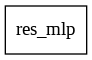

In [ ]:
keras.utils.plot_model(resmlp, show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       expand_nested=False,
                       show_layer_activations=True,
                       show_trainable=True,)



---



# ⚛ DiagnosticMLP (proposed model)

In [ ]:
class DiagnosticMLP(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)
        self.mlp3 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.channel_projection2 = layers.Dense(units=embedding_dim)
        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )
        # Add skip connection.
        x = x + inputs
        ########################################################################
        # Apply layer normalization.
        x = self.normalize(x)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        ########################################################################
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.mlp3(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        x= x + x_projected
        return x

In [ ]:
DiagnosticMLP_blocks = keras.Sequential(
    [DiagnosticMLP(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
DiagnosticMLP_classifier = build_classifier(DiagnosticMLP_blocks)

In [ ]:
DiagnosticMLP_classifier.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 data_augmentation (Sequent  (None, 64, 64, 3)         7         
 ial)                                                            
                                                                 
 patches_3 (Patches)         (None, 64, 192)           0         
                                                                 
 dense_83 (Dense)            (None, 64, 256)           49408     
                                                                 
 sequential_31 (Sequential)  (None, 64, 256)           973824    
                                                                 
 global_average_pooling1d_4  (None, 256)               0         
  (GlobalAveragePooling1D)                                 

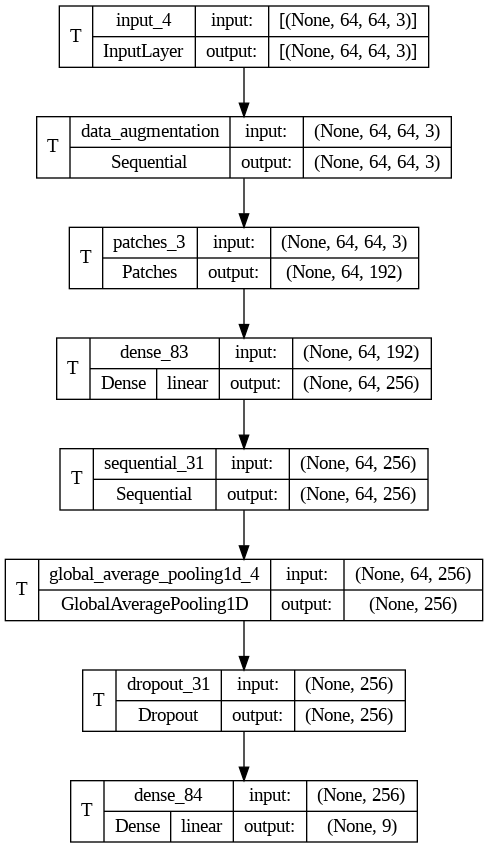

In [ ]:
keras.utils.plot_model(DiagnosticMLP_classifier, show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       expand_nested=False,
                       show_layer_activations=True,
                       show_trainable=True,)



---

